## Hotspot Assignment

Here are the steps used to assign hotspot to storm cells and then to trim off hotspots
that are not assigned. 

### Step 1: Breakup Large Hotspots

Occasionaly things go wrong. Maybe the level of -10C is inaccurate or there is a general latent heat release or a long line of cells from a QLCS approaches. But the main error in the hotspots algorithm is that it can make very large hotspots when things go wrong. Step 1 trys to deal with this realtime event. In a science environment one can investigate the 'why' and perhaps make a correction to the lower limit of the hotspot detection (0.2 -> 0.3...) or to increase the height of the -10C level but in operations this is impossible and the algorithm needs to self correct. The breakup of large hotspots is the self correcting part. As such it is last to be implemented, but when it is it will look for large hotspots that cover multiple storm cells and then break them into smaller versions by raising the 0.2 threhsold. 

### Step 2: Find the centeral hotspot for each StormCell. 

This step looks at each hotspot that overlaps an MCIT cell and selects the one where the max Zdr value is closes to the max storm cell value (VIL for MCIT). This is the central updraft and then....

### Step 3: Add additional updrafts to the central one

This steps looks near the central hotspot and adds to it hotspots that are nearby and likely associated with this hotspot. The reason for this is the opposite of step 1. Sometimes large hail when mixed into an updraft can lower the zdr values so that a hotspot is lost (see Krause and Klaus, fig 12.) This steps seeks to combine hotspots that have been seperated for whatever reason back into a single id. 

### Step 4: Trim Hotspots, compute hotspot statistics and output new hotspot data 
Now we remove hotspots that are not assigned to stormcells and to output our final analysis. Finally it seems that most users would want to output things like area and width and strength of hotspots, so we have added this recently.

In [1]:
#include some useful things
import matplotlib.pyplot as plt
from pathlib import Path
import datetime as dt
import numpy as np
import xarray as xr

import pyart
from stormcell.StormcellXY import LocXY, Stormcell



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
from config import _EXAMPLEDATA_DIR

file1 = Path(_EXAMPLEDATA_DIR, "KTLX20130520/MCIT", "MCITobj_20130520_190411.nc") #StormID
#Read in the stormcell data
mcit_data = xr.load_dataset(file1)
file2 = Path(_EXAMPLEDATA_DIR, "KTLX20130520/hotspots_raw", "ZdrHotSpot_20130520_190411.nc") #Raw Hotspots (same time)
hs_data = xr.load_dataset(file2)

In [3]:
mcit_data

<xarray.Dataset>
Dimensions:  (x: 600, y: 600)
Coordinates:
  * x        (x) int64 -300 -299 -298 -297 -296 -295 ... 294 295 296 297 298 299
  * y        (y) int64 -300 -299 -298 -297 -296 -295 ... 294 295 296 297 298 299
    lon      (x) float64 -100.5 -100.5 -100.5 -100.4 ... -93.89 -93.88 -93.87
    lat      (y) float64 32.59 32.6 32.61 32.62 ... 37.95 37.96 37.97 37.97
Data variables:
    MCIT     (y, x) int64 -1 -1 -1 -1 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1 -1 -1 -1
    VIL      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan

In [4]:
hs_data

<xarray.Dataset>
Dimensions:           (x: 600, y: 600)
Coordinates:
    z                 float64 5.2e+03
  * x                 (x) int64 -300 -299 -298 -297 -296 ... 295 296 297 298 299
  * y                 (y) int64 -300 -299 -298 -297 -296 ... 295 296 297 298 299
    lon               (x) float64 -100.5 -100.5 -100.5 ... -93.89 -93.88 -93.87
    lat               (y) float64 32.59 32.6 32.61 32.62 ... 37.96 37.97 37.97
Data variables:
    hotspot_field     (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    hotspot_features  (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [5]:
obj1 = mcit_data["MCIT"]
data1 = mcit_data["VIL"]
obj2 = hs_data["hotspot_features"]
data2 = hs_data["hotspot_field"]

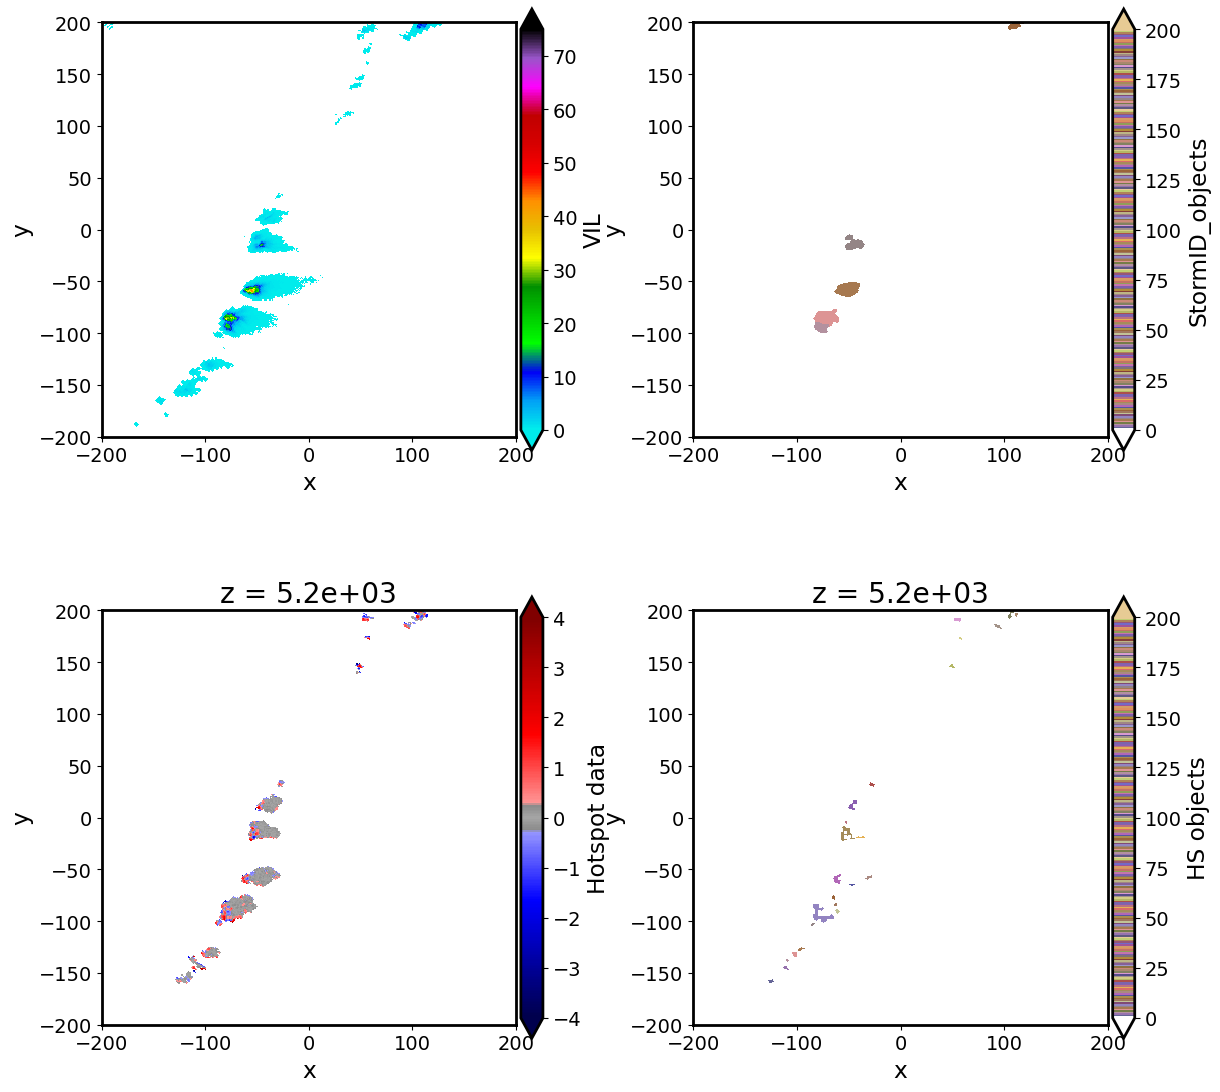

In [6]:
#plot our inputs for visualization
import klaus_krause_cmap

hs_cmap = klaus_krause_cmap.get_hs_cmap(3)
zdr_cmap = klaus_krause_cmap.get_zdr_cmap(-2, 5)
obj_cmap = klaus_krause_cmap.get_obj_cmap()

plt.rcParams.update(plt.rcParamsDefault)
#plt.style.use('dark_background')

plt.rcParams.update(
        {'font.size': 14.0,
         'axes.titlesize': 'x-large',
         'axes.linewidth': 2.0,
         'axes.labelsize': 'large'}
    )

axislabels = ["X (km)", "Y (km)"]
axisXlabels = ["X (km)", ""]
axisYlabels = ["", "Y (km)"]
axisnonelabels = ["", ""]
xlim = [-200, 200]
ylim = [-200, 200]
xdiff = xlim[1] - xlim[0]
axps = xdiff * 0.075
ayps = xdiff * 0.025

fig = plt.figure(figsize=(14, 14))


ax1 = fig.add_subplot(221)
ax1.set_aspect('equal')
ax1.set_ylabel('')
ax1.set_title("")
data1.plot(ax=ax1, x='x', y='y',
                              vmin=0.0, vmax=75.0,
                              xlim=xlim, ylim=ylim,
                              cmap='pyart_NWSRef',
                              add_colorbar=True,
        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'VIL', 'shrink':0.9}
                                           )


ax2 = fig.add_subplot(222)
ax2.set_aspect('equal')
ax2.set_ylabel('')
ax2.set_title("")

obj1.where(obj1>0).plot(ax=ax2, x='x', y='y',
                              vmin=0.0, vmax=200.0,
                              xlim=xlim, ylim=ylim,
                              cmap=obj_cmap,
                              add_colorbar=True,
        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'StormID_objects', 'shrink':0.9}
         )

ax3 = fig.add_subplot(223)
ax3.set_aspect('equal')
ax3.set_ylabel('')
ax3.set_title("")
data2.plot(ax=ax3, x='x', y='y',
                              vmin=-4.0, vmax=4.0,
                              xlim=xlim, ylim=ylim,
                      cmap=hs_cmap,
                              add_colorbar=True,
        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'Hotspot data', 'shrink':0.9}
                                           )


ax4 = fig.add_subplot(224)
ax4.set_aspect('equal')
ax4.set_ylabel('')
ax4.set_title("")

obj2.plot(ax=ax4, x='x', y='y',
                              vmin=0.0, vmax=200.0,
                              xlim=xlim, ylim=ylim,
                              cmap=obj_cmap,
                              add_colorbar=True,
        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'HS objects', 'shrink':0.9}
         )
plt.show()

In [7]:
#create stormcell objects of each
from stormcell.stormcell_helpers import create_stormcell_list
StormID_celllist = create_stormcell_list(mcit_data["MCIT"],mcit_data["VIL"] )
HS_celllist = create_stormcell_list(hs_data["hotspot_features"],hs_data["hotspot_field"] )


### Step 1: Breakup Large Hotspots (missing)


### Step 2: Find the centeral hotspot for each StormCell. 

In [8]:
#find and match the first (central) HS object
from stormcell.stormcell_helpers import rank_stormcell_list, find_stormcell_index
StormID_ranks = rank_stormcell_list(StormID_celllist)

HS_ranks = rank_stormcell_list(HS_celllist)


In [9]:
print("StormID by ID:rank:size:strength")
for key, value in StormID_ranks.items():
    stormcell =  StormID_celllist[find_stormcell_index(key, StormID_celllist)]
    size = stormcell.size
    strength = stormcell.max_value
    print(f"{key}: {value} : {size} : {strength}")

StormID by ID:rank:size:strength
5: 0.4 : 269.0 : 43.474989558811615
4: 1.0 : 275.0 : 32.529406281475566
6: 2.8 : 169.0 : 21.087482932149513
3: 4.6 : 101.0 : 19.42949582340459
10: 5.2 : 142.0 : 14.471533780375275


### Iterate through each StormID and find a hotspot that is close to it

In [10]:
# make a list of unassigned hotspots
unassigned_hotspots = HS_celllist.copy()

# make a dictionary: StormID as key, value: assigned hotspot object
StormIDHS_dict = dict()

for storm_id in StormID_ranks.keys():
    stormcell =  StormID_celllist[find_stormcell_index(storm_id, StormID_celllist)]
    storm_center = stormcell.center_location
    
    #print("storm id %d size: %d" % (stormcell.id, stormcell.size))
    StormIDHS_dict[storm_id] = dict(hotspots=[])
    
    hs_matched=[]

    #for the first detection
    primary_distance_threshold = max(
            np.sqrt(stormcell.size / np.pi), 10)
    
    #for additional detections
    secondary_distance_threshold = 12
        
    primary_hotspot = None
    
    HS_ranks = rank_stormcell_list(unassigned_hotspots) 
    #First pass objective find the primary hotspot within the distance thresh
    for hotspot_id in HS_ranks.keys():
        hotspot_cell = unassigned_hotspots[find_stormcell_index(hotspot_id, unassigned_hotspots)]
        hotspot_center = hotspot_cell.center_location

        #without overlap we don't consider this hotspot
        if stormcell.check_overlap(hotspot_cell) is False:
            continue
            
        # if no hotspot has been added yet, we check if it is close enough
        # to the MCIT cell center and then decide if we add it as primary
        # hotspot
        if primary_hotspot is None:
            distance = hotspot_center.get_distance(storm_center)
            #print("stormid: %d distance to hs %d:%f" %(stormcell.id, hotspot_cell.id, distance))
            if distance > primary_distance_threshold:
                continue
    
            primary_hotspot = hotspot_cell.id
            # now let's finally do the assignment if the hotspot object has
            # passed all checks up to now
            #print(f"assigning to MCIT ID {stormcell.id} (size {stormcell.size}): "
            #  f"Hotspot ID {hotspot_cell.id} (size {hotspot_cell.size}) as first hotspot")
            #StormIDHS_dict[stormcell.id]['hotspots'][hotspot_cell.id] = (hotspot_cell)
            hs_matched.append(hotspot_cell.id)

            # remove from the list of available hotspots
            unassigned_hotspots.remove(hotspot_cell)
            del HS_ranks[hotspot_cell.id]
            break
           
    #rerank so that we only look at unassigned hotspots
    HS_ranks = rank_stormcell_list(unassigned_hotspots)    
    #Second pass objective find the primary hotspot within the distance thresh or add additional hotspots
    #to the primary one. FIXME why not a third pass with additional instead
    #
    min_dist = 99999
    for hotspot_id in HS_ranks.keys():
        hotspot_cell = unassigned_hotspots[find_stormcell_index(hotspot_id, unassigned_hotspots)]
        hotspot_center = hotspot_cell.center_location

        #we don't check for overlap on the second pass only distance.....This might change
        #without overlap we don't consider this hotspot
        #if stormcell.check_overlap(hotspot_cell) is False:
        #    continue
            
        # if no hotspot has been added yet, we check if it is close enough
        # to the MCIT cell center and then decide if we add it as primary
        # hotspot
        if primary_hotspot is None:
            distance = hotspot_center.get_distance(storm_center)
            if distance < min_dist:
                min_dist = distance
                min_id = hotspot_id
            #print("stormid: %d distance to hs %d:%f" %(stormcell.id, hotspot_cell.id, distance))
            if distance > secondary_distance_threshold:
                continue
                
            primary_hotspot = hotspot_cell.id
            # now let's finally do the assignment if the hotspot object has
            # passed all checks up to now
            #print(f"assigning to MCIT ID {stormcell.id} (size {stormcell.size}): "
            #  f"Hotspot ID {hotspot_cell.id} (size {hotspot_cell.size}) as first hotspot")
            #StormIDHS_dict[stormcell.id]['hotspots'][hotspot_cell.id] = (hotspot_cell)
            hs_matched.append(hotspot_cell.id)

            # remove from the list of available hotspots
            unassigned_hotspots.remove(hotspot_cell)
            #del HS_ranks[hotspot_cell.id]
            
        else:
            if stormcell.check_overlap(hotspot_cell) is False:
                continue
            #print("Primary:", primary_hotspot)
            #storm has a primary hotspot. Use that for distance computations
            primary_hotspot_cell = HS_celllist[find_stormcell_index(primary_hotspot, HS_celllist)]
            primary_hotspot_center = primary_hotspot_cell.center_location
            distance = hotspot_center.get_distance(primary_hotspot_center)
            if distance > secondary_distance_threshold:
                continue
            #print(f"assigning to MCIT ID {stormcell.id} (size {stormcell.size}): "
            #  f"Hotspot ID {hotspot_cell.id} (size {hotspot_cell.size}) as additional")
            #StormIDHS_dict[stormcell.id]['hotspots'][hotspot_cell.id] = (hotspot_cell)
            hs_matched.append(hotspot_cell.id)
            # remove from the list of available hotspots
            unassigned_hotspots.remove(hotspot_cell)
            #del HS_ranks[hotspot_cell.id]
            
            
    if primary_hotspot is None:
        print("StormCell: ", stormcell.id)
        print(" NONE min_dist: ", min_dist, " hs_id: ", min_id)
    else:
        print("StormCell: ", stormcell.id)
        for h in hs_matched:
            print(" hs:", h)
        
    StormIDHS_dict[stormcell.id]['hotspots'] = hs_matched
    

StormCell:  5
 hs: 12
StormCell:  4
 NONE min_dist:  12.041594578792296  hs_id:  10
StormCell:  6
 hs: 15
StormCell:  3
 hs: 7
StormCell:  10
 hs: 24
 hs: 23


In [11]:
print("StormID by ID:size:strength:hotspot ids")
for key, value in StormID_ranks.items():
    stormcell =  StormID_celllist[find_stormcell_index(key, StormID_celllist)]
    size = stormcell.size
    strength = stormcell.max_value
    hotspots = StormIDHS_dict[key]['hotspots']
    print(f"{key}: {size} : {strength}: {hotspots}")

StormID by ID:size:strength:hotspot ids
5: 269.0 : 43.474989558811615: [12]
4: 275.0 : 32.529406281475566: []
6: 169.0 : 21.087482932149513: [15]
3: 101.0 : 19.42949582340459: [7]
10: 142.0 : 14.471533780375275: [24, 23]


In [12]:
hotspot_labels = hs_data["hotspot_features"]
valid_hotspots = []
for cell_id in StormIDHS_dict:
    for hotspot_id in StormIDHS_dict[cell_id]['hotspots']:
        valid_hotspots.append(hotspot_id)

print("valid hotspot ids: ", valid_hotspots)

assigned_hotspots = hotspot_labels.where(np.isin(hotspot_labels, valid_hotspots), -1)



valid hotspot ids:  [12, 15, 7, 24, 23]


In [13]:
#hotspot_obj = hs_data["hotspot_field"]
#assigned_hotspots = hotspot_labels


In [14]:
#from hotspots.assignment import *
#assigned_hotspots = filter_assigned_hotspots(hotspot_obj,StormIDHS_dict)

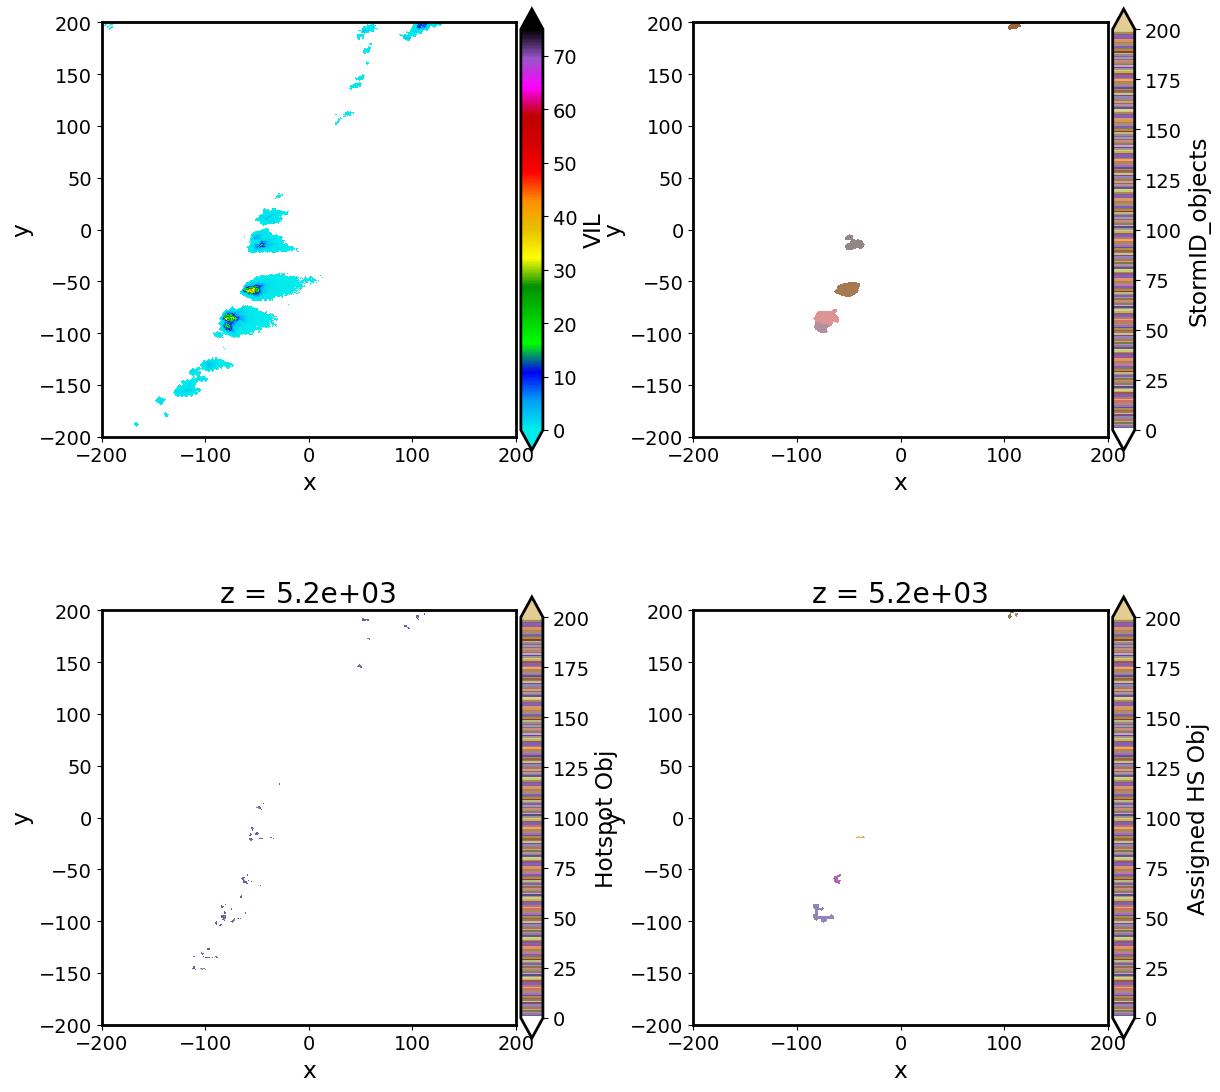

In [15]:
fig = plt.figure(figsize=(14, 14))


ax1 = fig.add_subplot(221)
ax1.set_aspect('equal')
ax1.set_ylabel('')
ax1.set_title("")
data1.plot(ax=ax1, x='x', y='y',
                              vmin=0.0, vmax=75.0,
                              xlim=xlim, ylim=ylim,
                              cmap='pyart_NWSRef',
                              add_colorbar=True,
        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'VIL', 'shrink':0.9}
                                           )


ax2 = fig.add_subplot(222)
ax2.set_aspect('equal')
ax2.set_ylabel('')
ax2.set_title("")

obj1.plot(ax=ax2, x='x', y='y',
                              vmin=0.0, vmax=200.0,
                              xlim=xlim, ylim=ylim,
                              cmap=obj_cmap,
                              add_colorbar=True,
        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'StormID_objects', 'shrink':0.9}
         )

ax3 = fig.add_subplot(223)
ax3.set_aspect('equal')
ax3.set_ylabel('')
ax3.set_title("")
hs_data["hotspot_field"].plot(ax=ax3, x='x', y='y',
                              vmin=0, vmax=200.0,
                              xlim=xlim, ylim=ylim,
                            cmap=obj_cmap,
                              add_colorbar=True,
        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'Hotspot Obj', 'shrink':0.9}
                                           )


ax4 = fig.add_subplot(224)
ax4.set_aspect('equal')
ax4.set_ylabel('')
ax4.set_title("")

assigned_hotspots.plot(ax=ax4, x='x', y='y',
                              vmin=0.0, vmax=200.0,
                              xlim=xlim, ylim=ylim,
                              cmap=obj_cmap,
                              add_colorbar=True,
        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'Assigned HS Obj', 'shrink':0.9}
         )
plt.show()

Text(0.5, 1.0, 'VIL with assigned Hotspots')

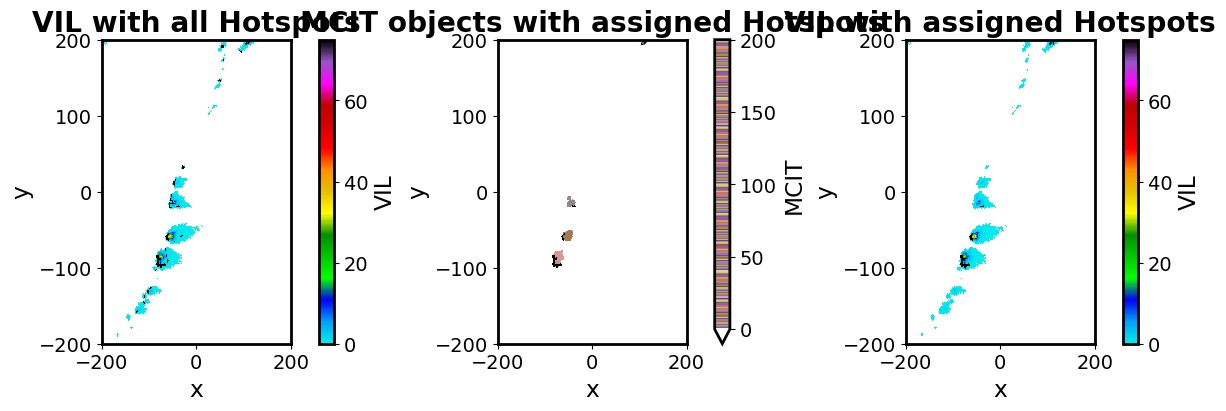

In [16]:
#plot
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# Create a color map that is just black
black_cmap = ListedColormap(['black'])
#black_cmap.set_under( list(0,0,0,0))
# Define the bounds and normalization
#bounds = [-100000, 0, 10000]
#norm = plt.Normalize(vmin=-1000, vmax=1000)
hotspot_features = hs_data["hotspot_features"]

obj_cmap = klaus_krause_cmap.get_obj_cmap()
fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

ax1 = axs[0]
data1.plot(x="x", y="y", xlim=xlim, ylim=ylim, cmap='pyart_NWSRef', vmin=0, vmax=75, ax=ax1)
hotspot_features.where(hotspot_features > 0).plot(
    x="x", y="y", xlim=xlim, ylim=ylim, cmap=black_cmap, add_colorbar=False,
    ax=ax1, vmin=0, vmax=200)
ax1.set_title('VIL with all Hotspots', fontweight='bold')

ax2 = axs[1]
obj1.plot( x="x", y="y", xlim=xlim, ylim=ylim, cmap=obj_cmap, ax=ax2, vmin=0, vmax=200)
assigned_hotspots.where(assigned_hotspots>0.25).plot(x="x", y="y", xlim=xlim, ylim=ylim, cmap=black_cmap, vmin=-1,
                   vmax=75, ax=ax2,add_colorbar=False )
ax2.set_title('MCIT objects with assigned Hotspots', fontweight='bold')





ax3 = axs[2]
data1.plot(x="x", y="y", xlim=xlim, ylim=ylim, cmap='pyart_NWSRef', vmin=0, vmax=75, ax=ax3)
assigned_hotspots.where(assigned_hotspots>0.25).plot(x="x", y="y", xlim=xlim, ylim=ylim, cmap=black_cmap, vmin=-1,
                   vmax=75, ax=ax3, add_colorbar=False)
ax3.set_title('VIL with assigned Hotspots', fontweight='bold')

## compute hotspot statistics